# Theme 1 - Ocean-Atmosphere Exchange
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

**Objective**: Demonstrate how to download pCO2 Air-Sea data from multiple arrays using the Machine-to-Machine (M2M) interface, remove outliers, calculate hourly averages, and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Coastal Endurance** - pCO2 Air-Sea data from the Oregon Shelf Surface Mooring
    * Instrument: CE02SHSM-SBD12-04-PCO2AA000
* **Coastal Pioneer** - pCO2 Air-Sea data from the Inshore Surface Mooring
    * Instrument: CP03ISSM-SBD12-04-PCO2AA000
* Time range: 2017-01-01 to 2018-01-01
* Delivery method: recovered_host
* Data streams: 
    * pco2a_a_dcl_instrument_water_recovered
    * pco2a_a_dcl_instrument_air_recovered
* Parameter names: 
    * measured_water_co2, partial_pressure_co2_ssw, pco2_co2flux
    * measured_air_co2, partial_pressure_co2_atm
    
There are 2 data streams for each pCO2 instrument that we want to get data from, so we will need to make a total of 4 data requests for the PCO2A instruments (because you must specifyy a data stream in a request).

As you will see later, we will need to manually calculate CO2 flux for the Pioneer dataset. This means we need to download two data streams from the collocated METBK data. We'll also download the Endurance METBK data to check the calculations.

* Instruments: CE02SHSM-SBD11-06-METBKA000 and CP03ISSM-SBD11-06-METBKA000
* Data streams & parameters: 
    * metbk_a_dcl_instrument_recovered: met_salsurf, sea_surface_temperature
    * metbk_hourly: met_wind10m

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for these instruments. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# CEwater_url = request_data('CE02SHSM-SBD12-04-PCO2AA000', 'recovered_host', 'pco2a_a_dcl_instrument_water_recovered',
#                            '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')

# CEair_url = request_data('CE02SHSM-SBD12-04-PCO2AA000', 'recovered_host', 'pco2a_a_dcl_instrument_air_recovered',
#                          '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')

# CEmet_url = request_data('CE02SHSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_a_dcl_instrument_recovered',
#                          '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')

# CEmet_hrly_url = request_data('CE02SHSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_hourly',
#                               '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')


# CPwater_url = request_data('CP03ISSM-SBD12-04-PCO2AA000', 'recovered_host', 'pco2a_a_dcl_instrument_water_recovered',
#                            '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')

# CPair_url = request_data('CP03ISSM-SBD12-04-PCO2AA000', 'recovered_host', 'pco2a_a_dcl_instrument_air_recovered',
#                          '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')

# CPmet_url = request_data('CP03ISSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_a_dcl_instrument_recovered',
#                          '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')

# CPmet_hrly_url = request_data('CP03ISSM-SBD11-06-METBKA000', 'recovered_host', 'metbk_hourly',
#                               '2017-01-01T00:00:00.000Z', '2018-01-01T00:00:00.000Z')

# print('CEwater_url = %s' %CEwater_url)
# print('CEair_url = %s' %CEair_url)
# print('CEmet_url = %s' %CEmet_url)
# print('CEmet_hrly_url = %s' %CEmet_hrly_url)
# print('CPwater_url = %s' %CPwater_url)
# print('CPair_url = %s' %CPair_url)
# print('CPmet_url = %s' %CPmet_url)
# print('CPmet_hrly_url = %s' %CPmet_hrly_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
CEwater_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191108T203500886Z-CE02SHSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_water_recovered/catalog.html'
CEair_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191108T203501159Z-CE02SHSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
CEmet_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191111T183245789Z-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
CEmet_hrly_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191111T183245949Z-CE02SHSM-SBD11-06-METBKA000-recovered_host-metbk_hourly/catalog.html'
CPwater_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191108T203501393Z-CP03ISSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_water_recovered/catalog.html'
CPair_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191108T203501636Z-CP03ISSM-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
CPmet_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191111T141307397Z-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
CPmet_hrly_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20191111T141307725Z-CP03ISSM-SBD11-06-METBKA000-recovered_host-metbk_hourly/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            try:
                units = ds[var].units
                if units not in unit_dict[var]:
                    unit_dict[var].append(units)
            except AttributeError:
                continue

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables of interest and get the data for these datasets. In this case, if you go to the opendap catalog links fpr the PCO2 data, you will see data files for different instruments and data streams that weren't specifically requested. All of these extra data files are included in the folder because parameters from those datasets are used to calculate CO2 flux.

We will request data from all of the different streams, downsample the data, then merge them together to make the dataset easier to work with.

The **get_data** function only opens files for the instrument and stream that was specifically requested: see the '# remove collocated data files if necessary' section. We'll do the Endurance dataset first since the CO2 flux variable is already calculated for us.

## Endurance pCO2 data

In [7]:
# Specify the variable(s) of interest and get the data
wvars = ['measured_water_co2', 'partial_pressure_co2_ssw', 'pco2_co2flux']
avars = ['measured_air_co2', 'partial_pressure_co2_atm']

CEwater_data, CEwater_units = get_data(CEwater_url, wvars)
CEair_data, CEair_units = get_data(CEair_url, avars)

print(CEwater_units)
print(CEair_units)

Appending data from files
Appending data from files
{'measured_water_co2': ['ppm'], 'partial_pressure_co2_ssw': ['µatm'], 'pco2_co2flux': ['mol m-2 s-1']}
{'measured_air_co2': ['ppm'], 'partial_pressure_co2_atm': ['µatm']}


In [8]:
# print out the first few lines of each dataset
CEwater_data.head()

,time,measured_water_co2,partial_pressure_co2_ssw,pco2_co2flux
54888,2017-01-01 00:57:11.454000128,333.269989,338.450345,NaN
54889,2017-01-01 00:57:11.635000320,333.190002,338.369109,NaN
54890,2017-01-01 00:57:13.234999808,333.119995,338.298020,NaN
54891,2017-01-01 00:57:14.848000000,333.070007,338.247255,NaN
54892,2017-01-01 00:57:16.435999744,333.079987,338.257402,NaN


In [9]:
CEair_data.head()

,time,measured_air_co2,partial_pressure_co2_atm
54891,2017-01-01 00:57:22.885999616,403.959991,411.036516
54892,2017-01-01 00:57:22.928000000,403.899994,410.975481
54893,2017-01-01 00:57:22.970999808,403.899994,410.975481
54894,2017-01-01 00:57:23.013000192,403.899994,410.975481
54895,2017-01-01 00:57:23.055000064,403.929993,411.005983


It looks like we have some data, so let's make some quick timeseries plots.

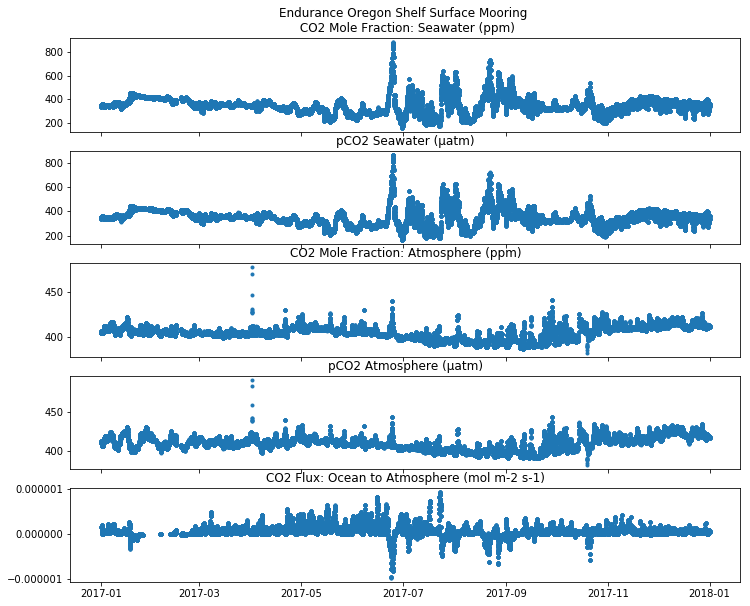

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
ax1.plot(CEwater_data['time'], CEwater_data['measured_water_co2'], '.')
ax2.plot(CEwater_data['time'], CEwater_data['partial_pressure_co2_ssw'], '.')
ax3.plot(CEair_data['time'], CEair_data['measured_air_co2'], '.')
ax4.plot(CEair_data['time'], CEair_data['partial_pressure_co2_atm'], '.')
ax5.plot(CEwater_data['time'], CEwater_data['pco2_co2flux'], '.')
ax1.set_title('Endurance Oregon Shelf Surface Mooring \n CO2 Mole Fraction: Seawater ({})'.format(CEwater_units['measured_water_co2'][0]))
ax2.set_title('pCO2 Seawater ({})'.format(CEwater_units['partial_pressure_co2_ssw'][0]))
ax3.set_title('CO2 Mole Fraction: Atmosphere ({})'.format(CEair_units['measured_air_co2'][0]))
ax4.set_title('pCO2 Atmosphere ({})'.format(CEair_units['partial_pressure_co2_atm'][0]))
ax5.set_title('CO2 Flux: Ocean to Atmosphere ({})'.format(CEwater_units['pco2_co2flux'][0]));

Now that we see we have a good time-series of data, let's calculate hourly averages and merge the two datasets.

In [11]:
# calculate hourly averages
CEwater_hourly = CEwater_data.resample('H', on='time').mean().dropna(how='all').reset_index()
CEair_hourly = CEair_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# merge the datasets
CEpco2_data = pd.merge(CEwater_hourly, CEair_hourly, on=['time'], how='outer')
CEpco2_data.head()

,time,measured_water_co2,partial_pressure_co2_ssw,pco2_co2flux,measured_air_co2,partial_pressure_co2_atm
0,2017-01-01 00:00:00,333.098887,338.276585,NaN,403.921109,410.996960
1,2017-01-01 01:00:00,341.310004,346.278497,NaN,404.074443,411.152970
2,2017-01-01 02:00:00,347.680003,352.054952,NaN,404.503333,411.190164
3,2017-01-01 03:00:00,346.908888,351.236097,NaN,404.811106,411.281068
4,2017-01-01 04:00:00,349.477780,353.530444,NaN,406.214450,412.929572


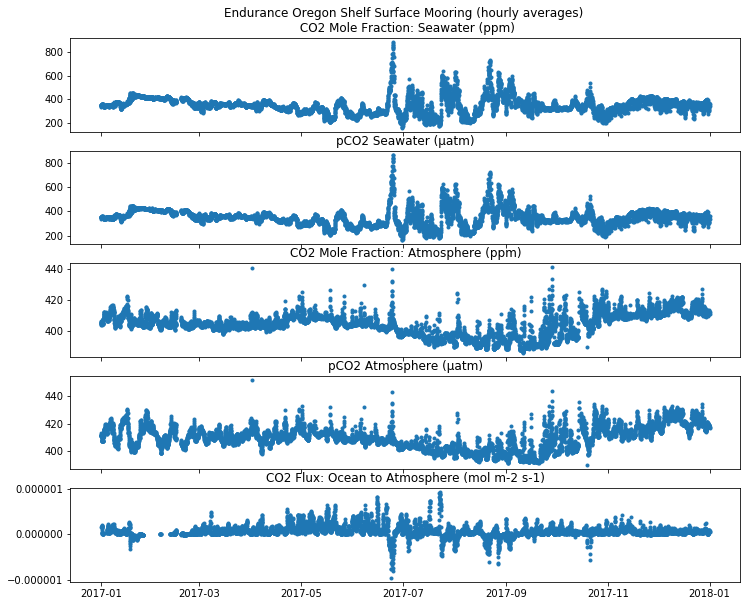

In [12]:
# plot the Endurance hourly averaged data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
ax1.plot(CEpco2_data['time'], CEpco2_data['measured_water_co2'], '.')
ax2.plot(CEpco2_data['time'], CEpco2_data['partial_pressure_co2_ssw'], '.')
ax3.plot(CEpco2_data['time'], CEpco2_data['measured_air_co2'], '.')
ax4.plot(CEpco2_data['time'], CEpco2_data['partial_pressure_co2_atm'], '.')
ax5.plot(CEpco2_data['time'], CEpco2_data['pco2_co2flux'], '.')
ax1.set_title('Endurance Oregon Shelf Surface Mooring (hourly averages) \n CO2 Mole Fraction: Seawater ({})'.format(CEwater_units['measured_water_co2'][0]))
ax2.set_title('pCO2 Seawater ({})'.format(CEwater_units['partial_pressure_co2_ssw'][0]))
ax3.set_title('CO2 Mole Fraction: Atmosphere ({})'.format(CEair_units['measured_air_co2'][0]))
ax4.set_title('pCO2 Atmosphere ({})'.format(CEair_units['partial_pressure_co2_atm'][0]))
ax5.set_title('CO2 Flux: Ocean to Atmosphere ({})'.format(CEwater_units['pco2_co2flux'][0]));

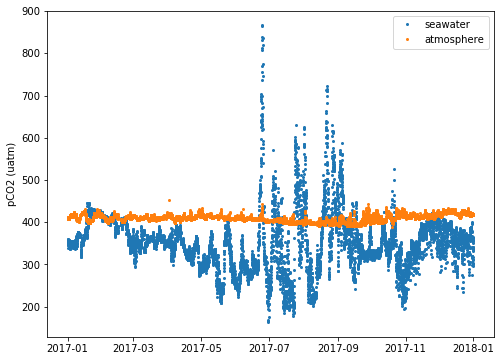

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(CEpco2_data['time'], CEpco2_data['partial_pressure_co2_ssw'], '.', markersize=4, label='seawater')
plt.plot(CEpco2_data['time'], CEpco2_data['partial_pressure_co2_atm'], '.', markersize=4, label='atmosphere')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('pCO2 (uatm)');

Since we have the CO2 Flux data for the Endurance dataset, let's use this to check the flux calculation we're going to use for the Pioneer dataset. We have to grab the collocated METBK data for this: the regular, high-resolution METBK dataset contains the sea surface slainity and temperature variables, and the hourly dataset contains the modeled windspeeds at 10m.

We can use the [pCO2 function](https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/co2_functions.py) the OOI system uses, aptly named pco2_co2flux (lines 374-440), copied below.

In [13]:
def pco2_co2flux(pco2w, pco2a, u10, t, s):
    """
    Description:
        OOI Level 2 core date product CO2FLUX is an estimate of the CO2 flux
        from the ocean to the atmosphere. It is computed using data from the
        pCO2 air-sea (PCO2A) and bulk meteorology (METBK) families of
        instruments.
    Implemented by:
        2012-03-28: Mathias Lankhorst. Original Matlab code.
        2013-04-20: Christopher Wingard. Initial python code.
    Usage:
        flux = pco2_co2flux(pco2w, pco2a, u10, t, s)
            where
        flux = estimated flux of CO2 from the ocean to atmosphere [mol m-2 s-1]
               (CO2FLUX_L2)
        pco2w = partial pressure of CO2 in sea water [uatm] (PCO2SSW_L1)
        pco2a = partial pressure of CO2 in air [uatm] (PCO2ATM_L1)
        u10 = normalized wind speed at 10 m height from METBK [m s-1] (WIND10M_L2)
        t = sea surface temperature from METBK [deg_C] (TEMPSRF_L1)
        s = sea surface salinity from METBK [psu] (SALSURF_L2)
    References:
        OOI (2012). Data Product Specification for Flux of CO2 into the
            Atmosphere. Document Control Number 1341-00270.
            https://alfresco.oceanobservatories.org/ (See: Company Home >>
            OOI >> Controlled >> 1000 System Level >>
            1341-00270_Data_Product_SPEC_CO2FLUX_OOI.pdf)
    """
    # convert micro-atm to atm
    pco2a = pco2a / 1.0e6
    pco2w = pco2w / 1.0e6

    # Compute Schmidt number (after Wanninkhof, 1992, Table A1)
    Sc = 2073.1 - (125.62 * t) + (3.6276 * t**2) - (0.043219 * t**3)

    # Compute gas transfer velocity (after Sweeney et al. 2007, Fig. 3 and Table 1)
    k = 0.27 * u10**2 * np.sqrt(660.0 / Sc)

    # convert cm h-1 to m s-1
    k = k / (100.0 * 3600.0)

    # Compute the absolute temperature
    T = t + 273.15

    # Compute solubility (after Weiss 1974, Eqn. 12 and Table I).
    # Note that there are two versions, one for units per volume and
    # one per mass. Here, the volume version is used.
    # mol atm-1 m-3
    T100 = T / 100
    K0 = 1000 * np.exp(-58.0931 + (90.5069 * (100/T)) + (22.2940 * np.log(T100)) +
                       s * (0.027766 - (0.025888 * T100) + (0.0050578 * T100**2)))

    # mol atm-1 kg-1
    #K0 = np.exp(-60.2409 + (93.4517 * (100/T)) + (23.3585 * np.log(T100)) +
    #            s * (0.023517 - (0.023656 * T100) + (0.0047036 * T100**2)))

    # Compute flux (after Wanninkhof, 1992, eqn. A2)
    flux = k * K0 * (pco2w - pco2a)
    return flux

In [14]:
met_vars = ['met_salsurf', 'sea_surface_temperature']
met_hrly_vars = ['met_wind10m']

CEmet_data, CEmet_units = get_data(CEmet_url, met_vars)
CEmet_hrly_data, CEmet_hrly_units = get_data(CEmet_hrly_url, met_hrly_vars)

print(CEmet_units)
print(CEmet_hrly_units)

Appending data from files
Appending data from files
{'met_salsurf': ['1'], 'sea_surface_temperature': ['ºC']}
{'met_wind10m': ['m s-1']}


In [15]:
CEmet_data.head()

,time,met_salsurf,sea_surface_temperature
365951,2017-01-01 00:00:20.701000192,31.620552,10.351
365952,2017-01-01 00:01:25.336999936,31.622817,10.353
365953,2017-01-01 00:02:29.750000128,31.623687,10.352
365954,2017-01-01 00:03:34.031000064,31.624032,10.347
365955,2017-01-01 00:04:38.347000320,31.623292,10.349


In [16]:
CEmet_hrly_data.head()

,time,met_wind10m
6102,2017-01-01 00:30:20.701000192,NaN
6103,2017-01-01 01:30:20.701000192,NaN
6104,2017-01-01 02:30:20.701000192,NaN
6105,2017-01-01 03:30:20.701000192,NaN
6106,2017-01-01 04:30:20.701000192,NaN


The salinity and temperature data are recorded about once every minute, and the wind speeds are from a derived data stream with hourly samples. The description of met_wind10m is "The modelled windspeed at a reference height of 10m". So, like we did for the pCO2 data, we'll calculate hourly averages for these datasets and merge them. Then we'll be able to calculate CO2 flux to compare against the flux provided in the file.

In [17]:
# replace fill values with NaNs
CEmet_hrly_data[CEmet_hrly_data == -9999999] = np.nan

In [18]:
# calculate hourly averages
CEmet_hourly = CEmet_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# taking the hourly average of the already hourly-averaged dataset will just get rid of NaN rows, and
# will reset the timestamp to be on the hour so it can easily be merged with the other datasets
CEmet_hourly2 = CEmet_hrly_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# merge the datasets
merge1 = pd.merge(CEmet_hourly, CEmet_hourly2, on=['time'], how='outer')
CEpco2_data = pd.merge(merge1, CEpco2_data, on=['time'], how='outer' )

CEpco2_data.head()

,time,met_salsurf,sea_surface_temperature,met_wind10m,measured_water_co2,partial_pressure_co2_ssw,pco2_co2flux,measured_air_co2,partial_pressure_co2_atm
0,2017-01-01 00:00:00,31.631327,10.369900,NaN,333.098887,338.276585,NaN,403.921109,410.996960
1,2017-01-01 01:00:00,31.658676,10.438467,NaN,341.310004,346.278497,NaN,404.074443,411.152970
2,2017-01-01 02:00:00,31.644223,10.436933,NaN,347.680003,352.054952,NaN,404.503333,411.190164
3,2017-01-01 03:00:00,31.592517,10.413050,NaN,346.908888,351.236097,NaN,404.811106,411.281068
4,2017-01-01 04:00:00,31.595512,10.418017,NaN,349.477780,353.530444,NaN,406.214450,412.929572


In [19]:
# use the pco2_co2flux function above
pco2w = np.array(CEpco2_data['partial_pressure_co2_ssw'])
pco2a = np.array(CEpco2_data['partial_pressure_co2_atm'])
u10 = np.array(CEpco2_data['met_wind10m'])
t = np.array(CEpco2_data['sea_surface_temperature'])
s = np.array(CEpco2_data['met_salsurf'])
co2flux_calc = pco2_co2flux(pco2w, pco2a, u10, t, s)

# add the resulting data to the dataframe
CEpco2_data['co2flux_calc'] = co2flux_calc
CEpco2_data.head()

,time,met_salsurf,sea_surface_temperature,met_wind10m,measured_water_co2,partial_pressure_co2_ssw,pco2_co2flux,measured_air_co2,partial_pressure_co2_atm,co2flux_calc
0,2017-01-01 00:00:00,31.631327,10.369900,NaN,333.098887,338.276585,NaN,403.921109,410.996960,NaN
1,2017-01-01 01:00:00,31.658676,10.438467,NaN,341.310004,346.278497,NaN,404.074443,411.152970,NaN
2,2017-01-01 02:00:00,31.644223,10.436933,NaN,347.680003,352.054952,NaN,404.503333,411.190164,NaN
3,2017-01-01 03:00:00,31.592517,10.413050,NaN,346.908888,351.236097,NaN,404.811106,411.281068,NaN
4,2017-01-01 04:00:00,31.595512,10.418017,NaN,349.477780,353.530444,NaN,406.214450,412.929572,NaN


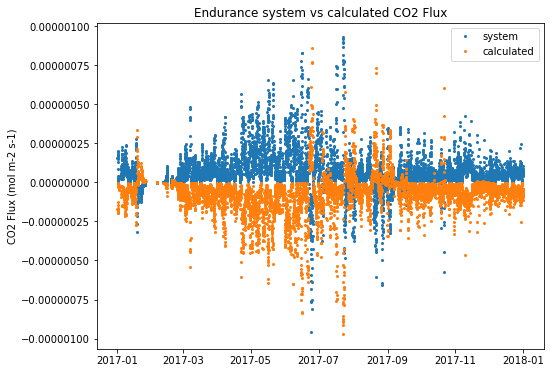

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(CEpco2_data['time'], CEpco2_data['pco2_co2flux'], '.', markersize=4, label='system')
plt.plot(CEpco2_data['time'], CEpco2_data['co2flux_calc'], '.', markersize=4, label='calculated')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('CO2 Flux (mol m-2 s-1)')
ax.set_title('Endurance system vs calculated CO2 Flux');

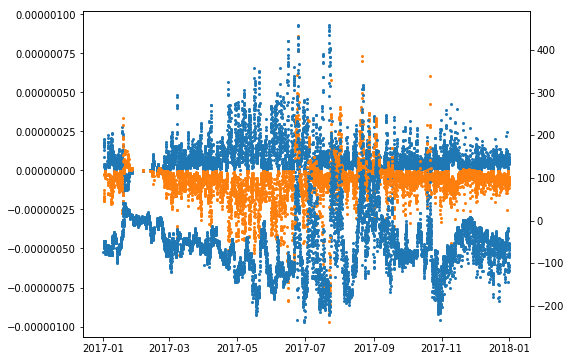

In [23]:
fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
ax1.plot(CEpco2_data['time'], CEpco2_data['pco2_co2flux'], '.', markersize=4, label='system')
ax1.plot(CEpco2_data['time'], CEpco2_data['co2flux_calc'], '.', markersize=4, label='calculated')
w_minus_a = CEpco2_data['partial_pressure_co2_ssw'] - CEpco2_data['partial_pressure_co2_atm']
ax2.plot(CEpco2_data['time'], w_minus_a, '.', markersize=4, label='w_minus_a')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('CO2 Flux (mol m-2 s-1)')
ax.set_title('Endurance system vs calculated CO2 Flux');

It looks like the function we used to calculate CO2 Flux provides the exact opposite of the CO2 Flux provided by the system. If we take the inverse of the function output it looks like we get approximately what the system provides. Small differences will exist because we calculated hourly averages of the data before calculating flux, and the OOI system doesn't do that.

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(CEpco2_data['time'], CEpco2_data['pco2_co2flux'], '.', markersize=8, label='system')
plt.plot(CEpco2_data['time'], -CEpco2_data['co2flux_calc'], '.', markersize=3, label='calculated')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('CO2 Flux (mol m-2 s-1)')
ax.set_title('Endurance system vs inverse calculated CO2 Flux');

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(CEpco2_data['pco2_co2flux'], -CEpco2_data['co2flux_calc'], '.', label='')
x = np.array([-0.0000009, -0.00000075, -0.00000025, 0, 0.00000025, 0.00000075, 0.000001])
y = np.array([-0.0000009, -0.00000075, -0.00000025, 0, 0.00000025, 0.00000075, 0.000001])
plt.plot(x, y, 'r-', label='1:1 line')
ax.legend()
ax.set_xlabel('CO2 Flux (System)')
ax.set_ylabel('CO2 Flux (Calculated)')
ax.set_title('Endurance system vs inverse calculated CO2 Flux');

The slope of the line isn't exactly 1 but it's close enough for our purposes. Let's replace the co2flux_calc column in the dataframe with the inverse of the calculated co2 flux.

In [ ]:
# add the inverse of the co2 flux calculation to the dataframe
CEpco2_data['co2flux_calc'] = -co2flux_calc

## Pioneer pCO2 data
Now let's try to wrangle the Pioneer dataset by first grabbing the data from the files.

In [ ]:
# Specify the variable(s) of interest and get the data
CPwater_data, CPwater_units = get_data(CPwater_url, wvars)
CPair_data, CPair_units = get_data(CPair_url, avars)

CPmet_data, CPmet_units = get_data(CPmet_url, met_vars)
CPmet_hrly_data, CPmet_hrly_units = get_data(CPmet_hrly_url, met_hrly_vars)

print(CPwater_units)
print(CPair_units)
print(CPmet_units)
print(CPmet_hrly_units)

In [ ]:
CPwater_data.head()

In [ ]:
CPair_data.head()

In [ ]:
# plot the Pioneer pCO2 data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
ax1.plot(CPwater_data['time'], CPwater_data['measured_water_co2'], 'g.')
ax2.plot(CPwater_data['time'], CPwater_data['partial_pressure_co2_ssw'], 'g.')
ax3.plot(CPair_data['time'], CPair_data['measured_air_co2'], 'g.')
ax4.plot(CPair_data['time'], CPair_data['partial_pressure_co2_atm'], 'g.')
ax5.plot(CPwater_data['time'], CPwater_data['pco2_co2flux'], 'g.')
ax1.set_title('Pioneer Inshore Surface Mooring \n CO2 Mole Fraction: Seawater ({})'.format(CPwater_units['measured_water_co2'][0]))
ax2.set_title('pCO2 Seawater ({})'.format(CPwater_units['partial_pressure_co2_ssw'][0]))
ax3.set_title('CO2 Mole Fraction: Atmosphere ({})'.format(CPair_units['measured_air_co2'][0]))
ax4.set_title('pCO2 Atmosphere ({})'.format(CPair_units['partial_pressure_co2_atm'][0]))
ax5.set_title('CO2 Flux: Ocean to Atmosphere ({})'.format(CPwater_units['pco2_co2flux'][0]));

First, note that there is a substantial jump in the pCO2 Atmosphere data in November. This mooring was turned over on Nov 1, 2017, and the new instrument was recording higher values than the old one. While there are no annotations in the system regarding this specific time frame, there is an annotation starting on 4/7/2019 that reads: 

_"Due to a firmware bug, the sensor zeroing function for correcting the baseline drift over time is not currently saving the new reference value to compare the raw CO2 value outputs during the measurements. The sensors are zeroing at the end of the sample cycle when scheduled, but the firmware is not storing the new value. This results in the original zero reference value being used for all measurements and an observable and consistent negative drift in both the air and water CO2 values. The vendor has indicated that the data may be correctable post-recovery, however at this time no such correction algorithm has been provided"_

It's unclear if this issue applies to previous deployments of these instruments, but note that sensor drift over deployment time frames is an issue.

You can also see from the bottom panel of this plot that the CO2 flux provided in the files is just an array of fill values (-9999999). There is an issue with the calculation in the OOI system for the Pioneer and Global Surface Moorings, which means we have to calculate that ourselves using the function that we tested with the Endurance data above. We'll downsample and merge the datasets before doing the calculation. Let's look at the data from the Pioneer METBK that we need for the calculation:

In [ ]:
CPmet_data.head()

In [ ]:
# replace fill values with NaNs
CPmet_hrly_data[CPmet_hrly_data == -9999999] = np.nan

CPmet_hrly_data.head()

Let's downsample and merge this dataset, just like we did for the Endurance dataset. Then we'll be able to calculate CO2 flux.

In [ ]:
# calculate hourly averages
CPwater_hourly = CPwater_data.resample('H', on='time').mean().dropna(how='all').reset_index()
CPair_hourly = CPair_data.resample('H', on='time').mean().dropna(how='all').reset_index()
CPmet_hourly = CPmet_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# taking the hourly average of the already hourly-averaged dataset will just get rid of NaN rows, and
# will reset the timestamp to be on the hour so it can easily be merged with the other datasets
CPmet_hourly2 = CPmet_hrly_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# merge the datasets
merge1 = pd.merge(CPwater_hourly, CPair_hourly, on=['time'], how='outer')
merge2 = pd.merge(merge1, CPmet_hourly, on=['time'], how='outer')
CPpco2_data = pd.merge(merge2, CPmet_hourly2, on=['time'], how='outer')

CPpco2_data.head()

In [ ]:
# use the pco2_co2flux function to calculate flux
pco2w = np.array(CPpco2_data['partial_pressure_co2_ssw'])
pco2a = np.array(CPpco2_data['partial_pressure_co2_atm'])
u10 = np.array(CPpco2_data['met_wind10m'])
t = np.array(CPpco2_data['sea_surface_temperature'])
s = np.array(CPpco2_data['met_salsurf'])
co2flux_calc = pco2_co2flux(pco2w, pco2a, u10, t, s)

# add the inverse of the output to the dataframe
CPpco2_data['co2flux_calc'] = -co2flux_calc
CPpco2_data.head()

Let's plot the Pioneer hourly averaged data, including the CO2 flux data we calculated.

In [ ]:
# plot the Pioneer hourly averaged data
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
ax1.plot(CPpco2_data['time'], CPpco2_data['measured_water_co2'], 'g.')
ax2.plot(CPpco2_data['time'], CPpco2_data['partial_pressure_co2_ssw'], 'g.')
ax3.plot(CPpco2_data['time'], CPpco2_data['measured_air_co2'], 'g.')
ax4.plot(CPpco2_data['time'], CPpco2_data['partial_pressure_co2_atm'], 'g.')
ax5.plot(CPpco2_data['time'], CPpco2_data['co2flux_calc'], 'g.')
ax1.set_title('Pioneer Inshore Surface Mooring (hourly averages) \n CO2 Mole Fraction: Seawater ({})'.format(CPwater_units['measured_water_co2'][0]))
ax2.set_title('pCO2 Seawater ({})'.format(CPwater_units['partial_pressure_co2_ssw'][0]))
ax3.set_title('CO2 Mole Fraction: Atmosphere ({})'.format(CPair_units['measured_air_co2'][0]))
ax4.set_title('pCO2 Atmosphere ({})'.format(CPair_units['partial_pressure_co2_atm'][0]))
ax5.set_title('CO2 Flux Calculated: Ocean to Atmosphere ({})'.format(CPwater_units['pco2_co2flux'][0]));

## 3. Merge and export
Now that we have the Endurance and Pioneer datasets cleaned up and downsampled, let's rename the columns, merge the datasets, and export as a .csv file.

In [ ]:
# first, drop the columns we don't need in the final export
CEpco2_data = CEpco2_data.drop(columns=['pco2_co2flux', 'met_salsurf', 'sea_surface_temperature', 'met_wind10m'])
CPpco2_data = CPpco2_data.drop(columns=['pco2_co2flux', 'met_salsurf', 'sea_surface_temperature', 'met_wind10m'])

In [ ]:
# rename the columns and add units
# Endurance
CEpco2_data = CEpco2_data.rename(columns={'measured_water_co2': 'CE CO2 Mole Fraction Seawater ({})'.format(CEwater_units['measured_water_co2'][0]),
                                         'partial_pressure_co2_ssw': 'CE pCO2 Seawater ({})'.format(CEwater_units['partial_pressure_co2_ssw'][0]),
                                         'co2flux_calc': 'CE CO2 Flux Calculated ({})'.format(CEwater_units['pco2_co2flux'][0]),
                                         'measured_air_co2':'CE CO2 Mole Fraction Atmosphere ({})'.format(CEair_units['measured_air_co2'][0]),
                                         'partial_pressure_co2_atm': 'CE pCO2 Atmosphere ({})'.format(CEair_units['partial_pressure_co2_atm'][0])})
# Pioneer
CPpco2_data = CPpco2_data.rename(columns={'measured_water_co2': 'CP CO2 Mole Fraction Seawater ({})'.format(CPwater_units['measured_water_co2'][0]),
                                         'partial_pressure_co2_ssw': 'CP pCO2 Seawater ({})'.format(CPwater_units['partial_pressure_co2_ssw'][0]),
                                         'co2flux_calc': 'CP CO2 Flux Calculated ({})'.format(CPwater_units['pco2_co2flux'][0]),
                                         'measured_air_co2':'CP CO2 Mole Fraction Atmosphere ({})'.format(CPair_units['measured_air_co2'][0]),
                                         'partial_pressure_co2_atm': 'CP pCO2 Atmosphere ({})'.format(CPair_units['partial_pressure_co2_atm'][0])})

In [ ]:
# merge the two datasets on time
pco2_data = pd.merge(CEpco2_data, CPpco2_data, on=['time'], how='outer')

pco2_data.head()

Let's plot the CO2 flux on the same graph

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(pco2_data['time'], pco2_data['CE CO2 Flux Calculated (mol m-2 s-1)'], '.', markersize=3, label='Endurance')
plt.plot(pco2_data['time'], pco2_data['CP CO2 Flux Calculated (mol m-2 s-1)'], '.', markersize=3, label='Pioneer')
ax.legend()
ax.set_xlabel('')
ax.set_ylabel('CO2 Flux (mol m-2 s-1)')
ax.set_title('Endurance vs Pioneer CO2 Flux');

In [ ]:
# export to .csv
pco2_data.to_csv(os.path.join(save_dir, 'Theme1_pCO2_CE02SHSM_CP03ISSM.csv'), index=False)